# Imports

In [1]:
!pip install -q PyWavelets fastai

In [2]:
import os
import random

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        f1_score, multilabel_confusion_matrix, accuracy_score, classification_report)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import pywt
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import torch.backends.cudnn as cudnn


def reproduce():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
reproduce()

In [4]:
print(torch.__version__)

2.0.0


# Preparing Data

In [5]:
!ls ../input/ptb-xl-100-hz
# !ls ../input/ptb-xl-lead-comparison

baseline_removed_100hz.npy


In [6]:
dataset_loc = "../input/ptb-xl-100-hz"

In [7]:
signals = np.load(os.path.join(dataset_loc, "baseline_removed_100hz.npy"))
signals.shape

(21388, 12, 1000)

In [8]:
faulty_index = 12498

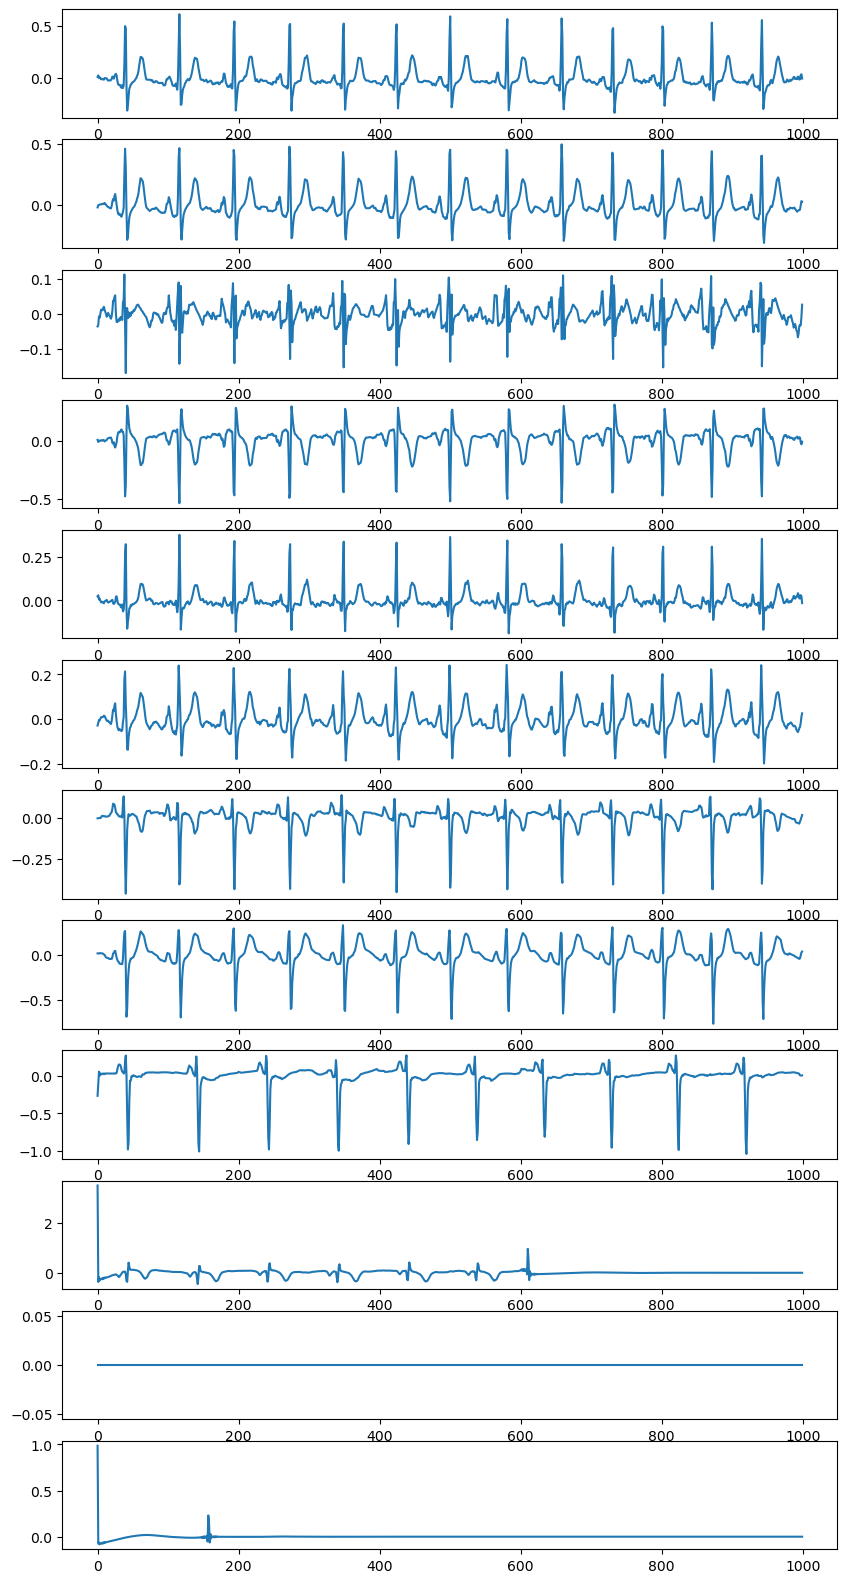

In [9]:
anomaly = signals[faulty_index]
fig, ax = plt.subplots(12, 1, figsize=(10, 20))
for i in range(12):
    ax[i].plot(anomaly[i])

In [10]:
signals = np.delete(signals, faulty_index, axis=0)
signals.shape

(21387, 12, 1000)

In [11]:
df = pd.read_csv("../input/ptb-xl-lead-comparison/labeled_df.csv")
df = df.drop(12498)
df = df.reset_index(drop=True)
df

,ecg_id,patient_id,age,sex,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21382,21833,17180.0,67.0,1,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,1,0,0
21383,21834,20703.0,300.0,0,4,records100/21000/21834_lr,records500/21000/21834_hr,1,0,0,0,0
21384,21835,19311.0,59.0,1,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,1,0,0
21385,21836,8873.0,64.0,1,8,records100/21000/21836_lr,records500/21000/21836_hr,1,0,0,0,0


In [12]:
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

In [13]:
classes2idx = {k:i for i, k in enumerate(classes)}
classes2idx

{'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

In [14]:
test_df = df[df['strat_fold'] == 10]
val_df = df[df['strat_fold'] == 9]
train_df = df[df['strat_fold'] <= 8]

In [15]:
test_signals = signals[test_df.index]
val_signals = signals[val_df.index]
train_signals = signals[train_df.index]

In [16]:
print(test_signals.shape)
print(val_signals.shape)
print(train_signals.shape)

(2158, 12, 1000)
(2146, 12, 1000)
(17083, 12, 1000)


In [17]:
# from the metadata of WFDB sample
leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

leads_index = {l:i for i, l in enumerate(leads)}
leads_index

{'I': 0,
 'II': 1,
 'III': 2,
 'AVR': 3,
 'AVL': 4,
 'AVF': 5,
 'V1': 6,
 'V2': 7,
 'V3': 8,
 'V4': 9,
 'V5': 10,
 'V6': 11}

# PyTorch Dataset Class

In [18]:
def decompose(signal, level=3, **kwargs):
    lvl = kwargs.get("level", level)
    return pywt.wavedec(signal, 'db6', level=lvl)[0]

def minmax_norm(sig, **kwargs):
    s_min, s_max = sig.min(), sig.max()
    s_norm = (sig - s_min) / (s_max - s_min)
    return s_norm

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [20]:
# device = "cpu" # for debugging

# Pretraining

In [21]:
class NextValuePredictionDataset(Dataset):
    def __init__(self, df, signals, lead, ctx_length, pred_length, transform=None, **kwargs):
        self.df = df
        self.signals = signals
    
        self.lead = lead
        self.ctx_length = ctx_length
        self.pred_length = pred_length
        self.total_length = ctx_length + pred_length
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
#         instance = self.df.iloc[idx] # data instance
        signal = self.signals[idx]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, **self.kwargs)
        
        max_index = signal.shape[-1] - self.total_length
        subset = signal[:, np.random.randint(0, max_index):]
        ctx = subset[:, :self.ctx_length]
        to_predict = subset[:,self.ctx_length:self.total_length]
        return torch.tensor(ctx).float(), torch.tensor(to_predict).float()

In [22]:
# ctx_length = 500
# pred_length = 100
# dataset = NextValuePredictionDataset(train_df, train_signals, lead="I", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
# dataset

In [23]:
# ctx, pred = dataset[0]
# ctx.shape, pred.shape

# Defining the architecture

In [24]:
  class ECGTransformerNVP(nn.Module):
    def __init__(self, ctx_length, pred_length, n_channels, n_filters=32, d_model=500, nhead=5, n_enc_layers=8):
        # AssertionError: embed_dim must be divisible by num_heads
        self.ctx_length, self.pred_length, self.n_channels = ctx_length, pred_length, n_channels
        self.n_filters = n_filters
        super().__init__()
#         self.conv_1 = nn.Conv1d(n_channels, n_filters, 8, stride=1, padding='same')
#         self.conv_2 = nn.Conv1d( n_filters, n_filters, 5, stride=1, padding='same')
#         self.conv_3 = nn.Conv1d( n_filters, n_filters, 3, stride=1, padding='same')
#         self.conv_4 = nn.Conv1d(n_channels, n_filters, 1, stride=1, padding='same')
        
        self.conv_1 = nn.Conv1d(n_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(n_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
#         self.pool = nn.MaxPool1d(kernel_size=2) # default stride is equal to the kernel_size
        self.flatten = nn.Flatten()
        self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        
#         self.linear_1 = nn.Linear(d_model*filters, 5)
#         self.classifier = nn.Sigmoid()
        self.fc_1 = nn.Linear(2*n_filters* ctx_length, pred_length*n_channels)
#         self.fc_2 = nn.Linear(512, pred_length*n_channels)

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
#         x = self.pool(d)
        x = self.encoder(output_3)
#         print(x.shape)
        x = self.flatten(x)
#         logits = self.linear_1(x)
#         print(x.shape)
#         x = self.fc_1(x)
#         logits = self.fc_2(x)
        logits = self.fc_1(x)
        return logits.view(-1, self.n_channels, self.pred_length)
#         return self.classifier(logits)

In [25]:
# base_model = ECGTransformerNVP(ctx_length,pred_length, n_channels=ctx.shape[0])

# # base_model(ctx.unsqueeze(0)).shape

In [26]:
# base_model(ctx.unsqueeze(0)).shape

# Pretraining once

In [27]:
# BATCH_SIZE = 32

In [28]:
# train_dataset = NextValuePredictionDataset(train_df, train_signals, lead="I", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
# val_dataset = NextValuePredictionDataset(val_df, val_signals, lead="I", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
# test_dataset = NextValuePredictionDataset(test_df, test_signals, lead="I", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)

# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
# for X, y in test_dataloader:
#     test_shape = X.shape
#     print(test_shape)
#     break

In [30]:
# base_model = ECGTransformerNVP(ctx_length,pred_length, n_channels=test_shape[1]).to(device) 
# dls = DataLoaders(train_dataloader, val_dataloader)
# loss_fn = nn.L1Loss()
# learner = Learner(
#     dls,
#     base_model,
#     loss_func=loss_fn,    
#     metrics=[mse, mae], # from fast ai
# )

In [31]:
# learner.fit(
#     30, 
#     lr=1e-3, 
#     cbs=[
#         EarlyStoppingCallback(monitor='valid_loss', comp=np.less, min_delta=0.0001,patience=10, reset_on_fit=True)
#     ]
# )

In [32]:
# learner.recorder.plot_loss()

In [33]:
# learner.model.eval()

# y_pred = []
# y_true = []
# with torch.no_grad():
#     for inputs, prediction in tqdm(test_dataloader):
#         output = learner.model(inputs.to(device).float())
#         y_pred.extend(output)
#         y_true.extend(prediction)
# y_true = torch.stack(y_true).cpu()
# y_pred = torch.stack(y_pred).cpu()

In [34]:
# mse_metric = mse(y_true, y_pred)
# mae_metric = mae(y_true, y_pred)

# print(f"MSE: {mse_metric}, MAE: {mae_metric}")

In [35]:
# index = np.random.randint(y_true.shape[0])
# fig, ax = plt.subplots(test_shape[1], 1, figsize=(10, 5))
# for i in range(test_shape[1]):
#     if test_shape[1] == 1:
#         ax.plot(y_pred[index][i])
#         ax.plot(y_true[index][i])
#     else:
#         ax[i].plot(y_pred[index][i])
#         ax[i].plot(y_true[index][i])

It's skipping the beats but the values are pretty close

# Fine-tuning for the disease detection

In [36]:
class DiseaseDetectionDataset(Dataset):
    def __init__(self, df, signals, lead, transform=None, **kwargs):
        self.df = df
        self.signals = signals
        self.lead = lead
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        instance = self.df.iloc[idx] # data instance
        label = train_df[classes].values[idx] #instance[self.k]
        signal = self.signals[idx]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, **self.kwargs)
        
        return torch.tensor(signal).float().to(device), torch.tensor(label, dtype=torch.float32).to(device)

In [37]:
# BATCH_SIZE = 32
# train_dataset_dd = DiseaseDetectionDataset(train_df, train_signals, "I", minmax_norm)
# val_dataset_dd = DiseaseDetectionDataset(val_df, train_signals, "I", minmax_norm)
# test_dataset_dd = DiseaseDetectionDataset(test_df, train_signals, "I", minmax_norm)

# train_dataloader_dd = DataLoader(train_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader_dd = DataLoader(val_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader_dd = DataLoader(test_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
# for x, y in test_dataloader_dd:
#     test_shape = x.shape
#     print(test_shape)
#     break

In [39]:
#  https://huggingface.co/transformers/v4.4.2/_modules/transformers/models/wav2vec2/modeling_wav2vec2.html
class ECGTransformerDD(nn.Module):
    def __init__(self, n_channels, d_model=500, n_filters = 32, nhead=5, n_enc_layers=8):
        # AssertionError: embed_dim must be divisible by num_heads
        super().__init__()
#         self.conv_1 = nn.Conv1d(n_channels, filters, 8, stride=1, padding='same')
#         self.conv_2 = nn.Conv1d(   filters, filters, 5, stride=1, padding='same')
#         self.conv_3 = nn.Conv1d(   filters, filters, 3, stride=1, padding='same')
#         self.conv_4 = nn.Conv1d(n_channels, filters, 1, stride=1, padding='same')
        self.conv_1 = nn.Conv1d(n_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(n_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        self.pool = nn.MaxPool1d(kernel_size=2) # default stride is equal to the kernel_size
        self.flatten = nn.Flatten()
        
#         self.encoder_layers = []
#         self.n_enc_layers = n_enc_layers
#         for i in range(n_enc_layers): 
#             self.encoder_layers.append(EncoderLayer(d_model, num_heads=nhead))
#         self.encoder = nn.Sequential(*[EncoderLayer(d_model, num_heads=nhead) for _ in range(n_enc_layers)])
        self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        
        self.linear_1 = nn.Linear(d_model*n_filters*2, 5)
#         self.classifier = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        x = self.pool(output_3)
#         for i in range(self.n_enc_layers):
#             x = self.encoder_layers[i](x)
        x = self.encoder(x)
#         print(x.shape)
        x = self.flatten(x)
        logits = self.linear_1(x)
        return logits
#         return self.classifier(logits)

In [40]:
# dd_model = ECGTransformerDD(n_channels=test_shape[1]).to(device) 
# # base_dd_model = ECGTransformerDD(n_channels=test_shape[1]).to(device) 
# dd_model(torch.randn(test_shape).to(device)).shape

In [41]:
def copy_weights(model_1, model_2):
    first_model_layers = set([c[0] for c in model_1.named_children()])
    second_model_layers = set([c[0] for c in model_2.named_children()])

    common_layers = list(first_model_layers.intersection(second_model_layers))
    common_layers.remove("flatten")
    with torch.no_grad():
        for layer in common_layers:
            print(layer)
            if layer == 'encoder':
                model_1.encoder.load_state_dict(model_2.encoder.state_dict())
                continue
            model_1.get_submodule(layer).weight.copy_(model_2.get_submodule(layer).weight)
            model_1.get_submodule(layer).bias.copy_(model_2.get_submodule(layer).bias)

In [42]:
# copy_weights(dd_model, base_model)

# Model with pretrained weights

In [43]:
# dls = DataLoaders(train_dataloader_dd, val_dataloader_dd)
# loss_fn = nn.BCEWithLogitsLoss()
# learner = Learner(
#     dls,
#     dd_model,
#     loss_func=loss_fn,    
#     metrics=[F1ScoreMulti(thresh=0.5, sigmoid=True, average="weighted")] # from fast ai
# )

In [44]:
# BCELossFlat?

In [45]:
# learner.fit(
#     50, 
#     1e-3,
# #     cbs=[
# #         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True)
# #     ]
# )

In [46]:
# learner.recorder.plot_loss()

In [47]:
# y_pred = []
# y_true = []
# with torch.no_grad():
#     for inputs, labels in tqdm(test_dataloader_dd):
#         output = dd_model(inputs.to(device).float())
# #         output = (output > 0.5).int()
#         y_pred.extend(output)
# #         labels = labels.data.cpu().int().numpy()
#         y_true.extend(labels)
# y_true = torch.stack(y_true).cpu()
# y_pred = torch.stack(y_pred).cpu()

In [48]:
# preds = (torch.sigmoid(y_pred) > 0.5).int()
# f1_score = F1ScoreMulti(sigmoid=False, average="weighted")
# f1_score(preds, y_true)

In [49]:
# preds, y_true

# Baseline model for comparison

In [50]:
# # dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
# dls = DataLoaders(train_dataloader_dd, val_dataloader_dd)
# loss_fn = nn.BCEWithLogitsLoss()
# learner = Learner(
#     dls,
#     base_dd_model,
#     loss_func=loss_fn,    
#     metrics=[F1ScoreMulti(thresh=0.5, sigmoid=True, average="weighted")] # from fast ai
# )

In [51]:
# learner.fit(
#     2, 
#     1e-3,
#     cbs=[
# #         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True),
#         SaveModelCallback(monitor='f1_score', min_delta=0.001)
#     ]
# )

In [52]:
# learner.recorder.plot_loss()
# plt.gca().set_title("Training and Validation loss")

In [53]:
# y_pred = []
# y_true = []
# with torch.no_grad():
#     for inputs, labels in tqdm(test_dataloader_dd):
#         output = base_dd_model(inputs.to(device).float())
# #         output = (output > 0.5).int()
#         y_pred.extend(output)
# #         labels = labels.data.cpu().int().numpy()
#         y_true.extend(labels)
# y_true = torch.stack(y_true).cpu()
# y_pred = torch.stack(y_pred).cpu()

In [54]:
# preds = (torch.sigmoid(y_pred) > 0.5).int()
# f1_score = F1ScoreMulti(thresh=0.5, sigmoid=False, average="weighted")
# f1_score(preds, y_true)

In [55]:
# matrices = multilabel_confusion_matrix(y_true, preds)

In [56]:
# disp = ConfusionMatrixDisplay(matrices[0])

In [57]:
# fig, ax = plt.subplots(1, matrices.shape[0], figsize=(20, 5))
# for disease,idx in classes2idx.items():
#     disp = ConfusionMatrixDisplay(matrices[idx])
#     ax[idx].set_title(disease)
#     disp.plot(ax=ax[idx], colorbar=False)

In [58]:
total_class_sum = df[['NORM', 'MI', 'STTC', 'CD', 'HYP']].sum()
total_class_sum

NORM    9514
MI      5468
STTC    5234
CD      4898
HYP     2649
dtype: int64

In [59]:
total_samples = total_class_sum.sum()
num_classes = len(classes)

In [60]:
class_weights = total_class_sum.apply(lambda x: total_samples/(x * num_classes))
class_weights

NORM    0.583624
MI      1.015472
STTC    1.060871
CD      1.133646
HYP     2.096112
dtype: float64

In [61]:
class_weights = torch.tensor(class_weights.values).to(device)

weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

In [62]:
# nn.BCEWithLogitsLoss(weight=class_weights)

# Experiment Design

Steps:

1. Create train, val, test loaders for NVP and DD (BATCH_SIZE, LEADS)
2. Create model instance (NVP, DD, BASE_DD)
3. Create Learner (Num channels --> any loader)
4. Train models (EPOCHS, filename for saving) <br>
    4.1 Train BASE_DD model <br>
    4.2 Train model for NVP <br>
    4.3 Copy weights from NVP to DD and then train <br>
5. Run on test loader 
6. Evaluate model
7. Save confusion matrix

In [63]:
def get_nvp_loaders(ctx_length, pred_length, batch_size, leads):
    train_dataset = NextValuePredictionDataset(train_df, train_signals, lead=leads, ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
    val_dataset = NextValuePredictionDataset(val_df, val_signals, lead=leads, ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
    test_dataset = NextValuePredictionDataset(test_df, test_signals, lead=leads, ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

In [64]:
def get_dd_loaders(batch_size, leads):
    # BATCH_SIZE = 32
    train_dataset_dd = DiseaseDetectionDataset(train_df, train_signals, leads, minmax_norm)
    val_dataset_dd = DiseaseDetectionDataset(val_df, train_signals, leads, minmax_norm)
    test_dataset_dd = DiseaseDetectionDataset(test_df, train_signals, leads, minmax_norm)

    train_dataloader_dd = DataLoader(train_dataset_dd, batch_size=batch_size, shuffle=True)
    val_dataloader_dd = DataLoader(val_dataset_dd, batch_size=batch_size, shuffle=True)
    test_dataloader_dd = DataLoader(test_dataset_dd, batch_size=batch_size, shuffle=True)

    return train_dataloader_dd, val_dataloader_dd, test_dataloader_dd

In [65]:
def get_models(ctx_length, pred_length, channels):
    nvp_model = ECGTransformerNVP(ctx_length,pred_length, n_channels=channels).to(device)
    dd_model = ECGTransformerDD(n_channels=channels).to(device) 
    base_dd_model = ECGTransformerDD(n_channels=channels).to(device) 
    
    return nvp_model, dd_model, base_dd_model

In [66]:
def get_nvp_learner(train_dataloader, val_dataloader, model):
    dls = DataLoaders(train_dataloader, val_dataloader)
    loss_fn = nn.L1Loss()
    learner = Learner(
        dls,
        model,
        loss_func=loss_fn,    
        metrics=[mse, mae], # from fast ai
    )
    
    return learner

In [67]:
def get_dd_learner(train_dataloader, val_dataloader, model):
    # dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
    dls = DataLoaders(train_dataloader, val_dataloader)
    loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
    learner = Learner(
        dls,
        model,
        loss_func=loss_fn,    
        metrics=[F1ScoreMulti(thresh=0.5, sigmoid=True, average="weighted")] # from fast ai
    )
    return learner

In [68]:
def fit_nvp(learner, epochs, lr=1e-3):
    learner.fit(
        epochs, 
        lr=lr, 
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', comp=np.less, min_delta=0.0001,patience=10, reset_on_fit=True)
        ]
    )

In [69]:
def fit_dd(learner, epochs, fname, lr=1e-3):
    learner.fit(
        epochs, 
        lr,
        cbs=[
    #         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True),
            SaveModelCallback(monitor='f1_score', min_delta=0.001, fname=fname)
        ]
    )

In [70]:
def save_learning_curve(learner, fname):
    learner.recorder.plot_loss()
    plt.gca().set_title(f"Training and Validation loss, {fname}")
    plt.savefig(f"plots/{fname}_learning_curve.png")

In [71]:
def test_model(learner, test_loader, fname):
    learner.model.load_state_dict(
        torch.load(f"models/{fname}.pth", map_location=torch.device(device)))
    learner.model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            output = learner.model(inputs.to(device).float())
    #         output = (output > 0.5).int()
            y_pred.extend(output)
    #         labels = labels.data.cpu().int().numpy()
            y_true.extend(labels)
    y_true = torch.stack(y_true).cpu()
    y_pred = torch.stack(y_pred).cpu()
    preds = (torch.sigmoid(y_pred) > 0.5).int()
    return y_true, preds

In [72]:
def evaluate(y_true, y_pred, fname):
    print(classification_report(y_true, y_pred, target_names=classes2idx.keys(), digits=4))
    matrices = multilabel_confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(1, matrices.shape[0], figsize=(20, 5))
    for disease,idx in classes2idx.items():
        disp = ConfusionMatrixDisplay(matrices[idx])
        ax[idx].set_title(disease)
        disp.plot(ax=ax[idx], colorbar=False)
    plt.savefig(f"plots/{fname}_confusion_matrix.png")

## Testing the pipeline

In [73]:
BATCH_SIZE = 32
EPOCHS = 100
ctx_length = 500
pred_length = 100

leads = "AVR"
#['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

In [74]:
os.mkdir("plots")

In [75]:
type(leads)

str

In [76]:
def run_pipeline(leads):
    if type(leads) is list:
        fname = "-".join(leads)
        channels = len(leads)
    else:
        fname = leads
        channels = 1
        
    # getting loaders
    train_loader_nvp, val_loader_nvp, test_loader_nvp = get_nvp_loaders(ctx_length, pred_length, BATCH_SIZE, leads)
    train_loader_dd, val_loader_dd, test_loader_dd = get_dd_loaders(BATCH_SIZE, leads)
    
    reproduce()
    nvp_model, dd_model, base_dd_model = get_models(ctx_length, pred_length, channels)
    
    nvp_learner = get_nvp_learner(train_loader_nvp, val_loader_nvp, nvp_model)
    dd_learner = get_dd_learner(train_loader_dd, val_loader_dd, dd_model)
    base_dd_learner = get_dd_learner(train_loader_dd, val_loader_dd, base_dd_model)
    
    # first we train base_dd_learner
    fit_dd(base_dd_learner, EPOCHS, f"{fname}_base_dd", lr=1e-3)
    
    fit_nvp(nvp_learner, 30, lr=1e-3)
    
    # copy weights
    copy_weights(dd_learner.model, nvp_learner.model)
    
    fit_dd(dd_learner, EPOCHS, f"{fname}_dd", lr=1e-3)
    save_learning_curve(base_dd_learner, f"{fname}_base_dd")
    plt.show()
    save_learning_curve(dd_learner, f"{fname}_dd")
    plt.show()
    
    print("Testing base model...")
    y_true, y_pred = test_model(base_dd_learner, test_loader_dd, f"{fname}_base_dd")
    evaluate(y_true, y_pred, f"{fname}_base_dd")
    plt.show()
    print("Testing pre-trained model...")
    y_true, y_pred = test_model(dd_learner, test_loader_dd, f"{fname}_dd")
    evaluate(y_true, y_pred, f"{fname}_dd")
    plt.show()

epoch,train_loss,valid_loss,f1_score,time
0,0.585990,0.535071,0.351595,00:44
1,0.577766,0.497195,0.384098,00:38
2,0.540109,0.478161,0.500802,00:38
3,0.525145,0.455737,0.514718,00:38
4,0.494407,0.398141,0.556351,00:38
5,0.464631,0.350192,0.656516,00:38
6,0.430759,0.293247,0.724329,00:38
7,0.352434,0.233444,0.812054,00:38
8,0.264256,0.141535,0.882537,00:38
9,0.195838,0.102845,0.928898,00:38


Better model found at epoch 0 with f1_score value: 0.35159464345471036.
Better model found at epoch 1 with f1_score value: 0.38409829388126504.
Better model found at epoch 2 with f1_score value: 0.500801896586824.
Better model found at epoch 3 with f1_score value: 0.5147175628965976.
Better model found at epoch 4 with f1_score value: 0.5563506468628583.
Better model found at epoch 5 with f1_score value: 0.6565157118146756.
Better model found at epoch 6 with f1_score value: 0.7243290815339466.
Better model found at epoch 7 with f1_score value: 0.8120537233630375.
Better model found at epoch 8 with f1_score value: 0.882537160831178.
Better model found at epoch 9 with f1_score value: 0.9288979690135907.
Better model found at epoch 10 with f1_score value: 0.9520380065049209.
Better model found at epoch 11 with f1_score value: 0.9623147271244165.
Better model found at epoch 13 with f1_score value: 0.9714645269804328.
Better model found at epoch 14 with f1_score value: 0.9762358589372708.
Be

epoch,train_loss,valid_loss,mse,mae,time
0,0.143993,0.138169,0.037762,0.138169,00:15
1,0.116212,0.105311,0.026709,0.105311,00:15
2,0.100100,0.095851,0.023641,0.095851,00:15
3,0.089012,0.085222,0.019762,0.085222,00:15
4,0.079650,0.073487,0.018741,0.073487,00:15
5,0.075094,0.073120,0.019151,0.073120,00:15
6,0.069875,0.066180,0.017448,0.066180,00:15
7,0.069212,0.066828,0.017953,0.066828,00:15
8,0.066761,0.063654,0.017407,0.063654,00:15
9,0.066495,0.064957,0.018044,0.064957,00:15


conv_12
norm_7
conv_11
conv_10
conv_3
norm_5
norm_2
conv_5
conv_4
norm_1
norm_8
norm_4
norm_12
norm_3
norm_6
encoder
conv_6
norm_11
conv_7
norm_9
conv_9
conv_8
conv_2
norm_10
conv_1


epoch,train_loss,valid_loss,f1_score,time
0,0.502801,0.469832,0.447197,00:37
1,0.495995,0.452735,0.470874,00:38
2,0.482586,0.476344,0.523835,00:37
3,0.472354,0.455040,0.487012,00:37
4,0.470365,0.443314,0.545567,00:37
5,0.456960,0.468318,0.494904,00:37
6,0.437859,0.384493,0.599481,00:38
7,0.427751,0.351043,0.671146,00:37
8,0.397319,0.309529,0.724216,00:38
9,0.381843,0.411734,0.612658,00:37


Better model found at epoch 0 with f1_score value: 0.44719671336160394.
Better model found at epoch 1 with f1_score value: 0.47087429343907916.
Better model found at epoch 2 with f1_score value: 0.5238347922107307.
Better model found at epoch 4 with f1_score value: 0.545567263229708.
Better model found at epoch 6 with f1_score value: 0.5994810629260058.
Better model found at epoch 7 with f1_score value: 0.6711458856382794.
Better model found at epoch 8 with f1_score value: 0.7242158299424017.
Better model found at epoch 10 with f1_score value: 0.7783999970048953.
Better model found at epoch 11 with f1_score value: 0.827155256327265.
Better model found at epoch 13 with f1_score value: 0.8440778058655486.
Better model found at epoch 14 with f1_score value: 0.8802731686519792.
Better model found at epoch 16 with f1_score value: 0.8954256655938772.
Better model found at epoch 17 with f1_score value: 0.9393293350891182.
Better model found at epoch 18 with f1_score value: 0.9501627597513727.

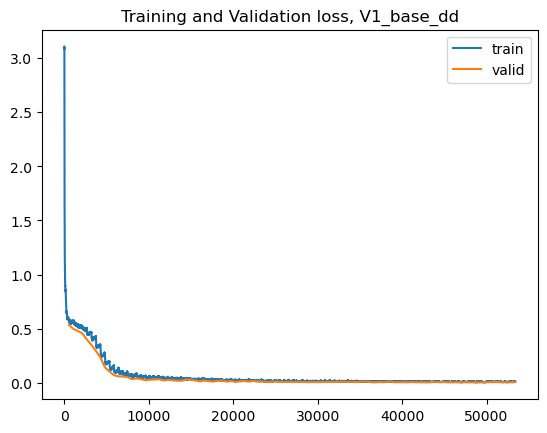

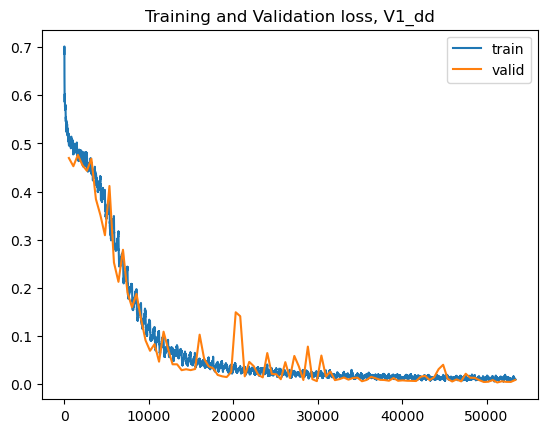

Testing base model...


  0%|          | 0/68 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NORM     1.0000    1.0000    1.0000      1189
          MI     1.0000    1.0000    1.0000       388
        STTC     0.9979    0.9979    0.9979       474
          CD     0.9979    0.9979    0.9979       470
         HYP     0.9956    1.0000    0.9978       224

   micro avg     0.9989    0.9993    0.9991      2745
   macro avg     0.9983    0.9992    0.9987      2745
weighted avg     0.9989    0.9993    0.9991      2745
 samples avg     0.9994    0.9995    0.9993      2745



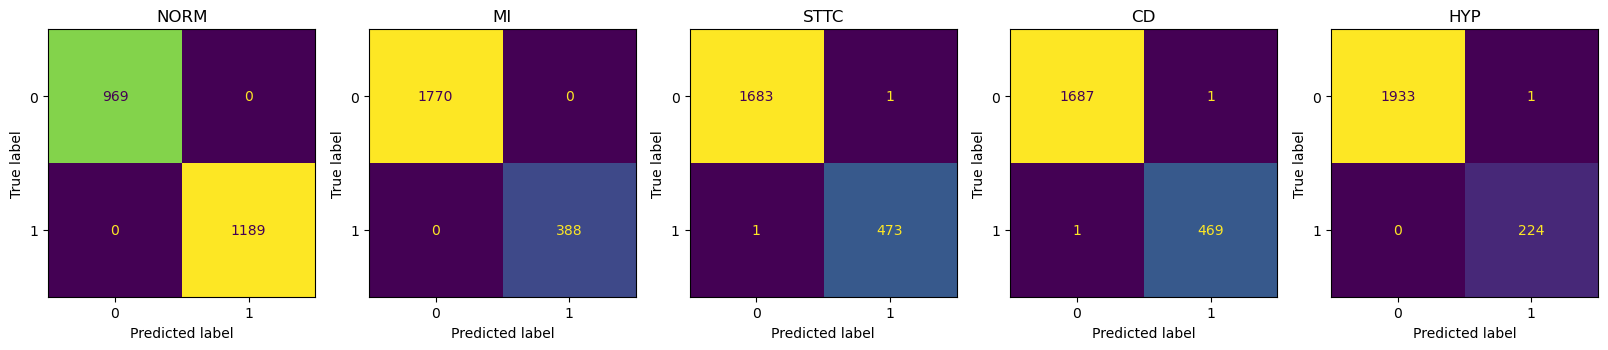

Testing pre-trained model...


  0%|          | 0/68 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NORM     0.9958    1.0000    0.9979      1189
          MI     0.9949    1.0000    0.9974       388
        STTC     1.0000    1.0000    1.0000       474
          CD     1.0000    0.9979    0.9989       470
         HYP     0.9955    0.9955    0.9955       224

   micro avg     0.9971    0.9993    0.9982      2745
   macro avg     0.9972    0.9987    0.9980      2745
weighted avg     0.9971    0.9993    0.9982      2745
 samples avg     0.9979    0.9994    0.9984      2745



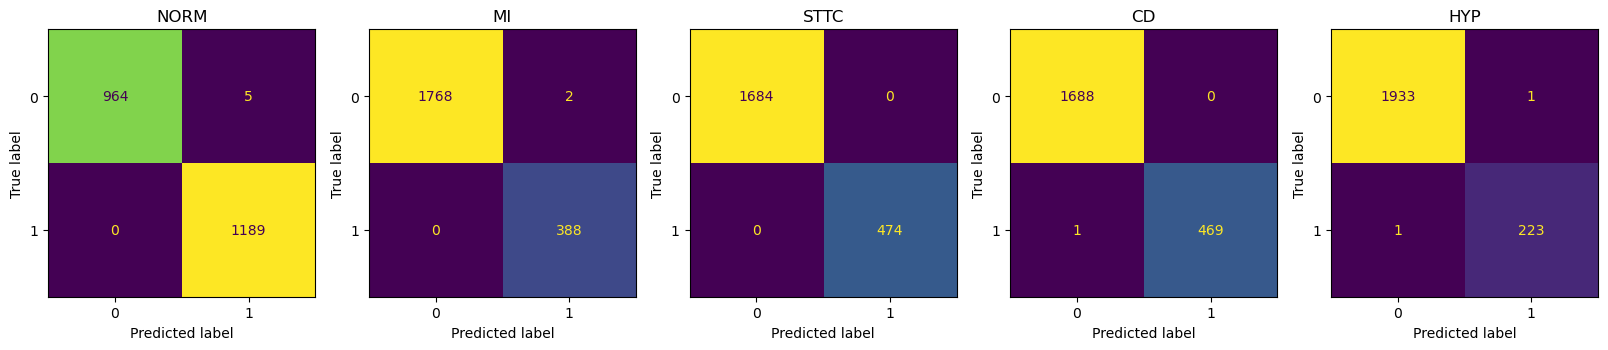

In [77]:
run_pipeline("V1")

epoch,train_loss,valid_loss,f1_score,time
0,0.592883,0.538269,0.352956,00:38
1,0.576643,0.509838,0.277145,00:38
2,0.542980,0.460180,0.522522,00:38
3,0.525033,0.474523,0.501892,00:38
4,0.500642,0.402204,0.585099,00:37
5,0.443354,0.323640,0.723070,00:38
6,0.376383,0.245873,0.789261,00:38
7,0.285182,0.152818,0.893318,00:38
8,0.208834,0.094649,0.929832,00:37
9,0.136047,0.063429,0.949661,00:37


Better model found at epoch 0 with f1_score value: 0.3529558674802897.
Better model found at epoch 2 with f1_score value: 0.5225216968538208.
Better model found at epoch 4 with f1_score value: 0.5850991706444258.
Better model found at epoch 5 with f1_score value: 0.7230702275875486.
Better model found at epoch 6 with f1_score value: 0.7892612991690561.
Better model found at epoch 7 with f1_score value: 0.8933178057406677.
Better model found at epoch 8 with f1_score value: 0.9298321522183899.
Better model found at epoch 9 with f1_score value: 0.9496609914391122.
Better model found at epoch 10 with f1_score value: 0.9667647973361504.
Better model found at epoch 11 with f1_score value: 0.9736285564363278.
Better model found at epoch 12 with f1_score value: 0.9750138942970469.
Better model found at epoch 13 with f1_score value: 0.9792088755216172.
Better model found at epoch 14 with f1_score value: 0.9813092736989444.
Better model found at epoch 15 with f1_score value: 0.9835511580745084.


epoch,train_loss,valid_loss,mse,mae,time
0,0.159515,0.138857,0.036637,0.138857,00:16
1,0.121791,0.116166,0.027463,0.116166,00:16
2,0.092957,0.087458,0.020011,0.087458,00:16
3,0.089288,0.093999,0.021429,0.093999,00:15
4,0.076978,0.070093,0.016143,0.070093,00:15
5,0.066564,0.066777,0.015274,0.066777,00:15
6,0.064412,0.066337,0.015146,0.066337,00:15
7,0.061217,0.060987,0.014376,0.060987,00:15
8,0.061158,0.074011,0.016384,0.074011,00:16
9,0.057656,0.058549,0.014186,0.058549,00:15


conv_12
norm_7
conv_11
conv_10
conv_3
norm_5
norm_2
conv_5
conv_4
norm_1
norm_8
norm_4
norm_12
norm_3
norm_6
encoder
conv_6
norm_11
conv_7
norm_9
conv_9
conv_8
conv_2
norm_10
conv_1


epoch,train_loss,valid_loss,f1_score,time
0,0.502064,0.462822,0.510324,00:37
1,0.495811,0.450975,0.525334,00:37
2,0.480182,0.445090,0.557819,00:38
3,0.466331,0.430787,0.544948,00:38
4,0.459624,0.429082,0.573986,00:38
5,0.434211,0.343688,0.662884,00:38
6,0.388792,0.301320,0.732913,00:38
7,0.348051,0.232812,0.806769,00:38
8,0.276448,0.156758,0.888822,00:38
9,0.216473,0.140676,0.897830,00:38


Better model found at epoch 0 with f1_score value: 0.51032358545051.
Better model found at epoch 1 with f1_score value: 0.5253343834015092.
Better model found at epoch 2 with f1_score value: 0.5578192954700427.
Better model found at epoch 4 with f1_score value: 0.573985781130683.
Better model found at epoch 5 with f1_score value: 0.6628841756989978.
Better model found at epoch 6 with f1_score value: 0.73291253855239.
Better model found at epoch 7 with f1_score value: 0.8067694328784201.
Better model found at epoch 8 with f1_score value: 0.8888223297836771.
Better model found at epoch 9 with f1_score value: 0.8978303608177717.
Better model found at epoch 10 with f1_score value: 0.9077864929179852.
Better model found at epoch 11 with f1_score value: 0.9436272236621309.
Better model found at epoch 12 with f1_score value: 0.9687781412842921.
Better model found at epoch 14 with f1_score value: 0.9698550490244378.
Better model found at epoch 15 with f1_score value: 0.9790771124453815.
Better

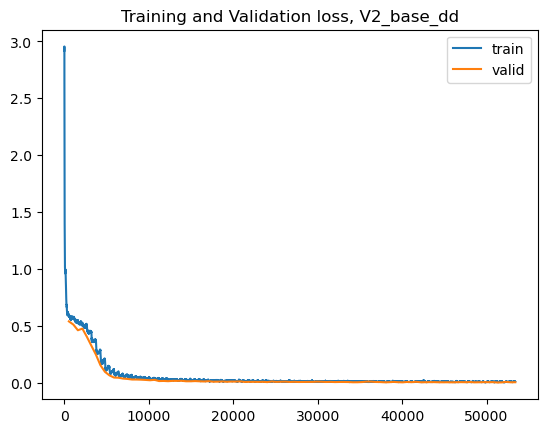

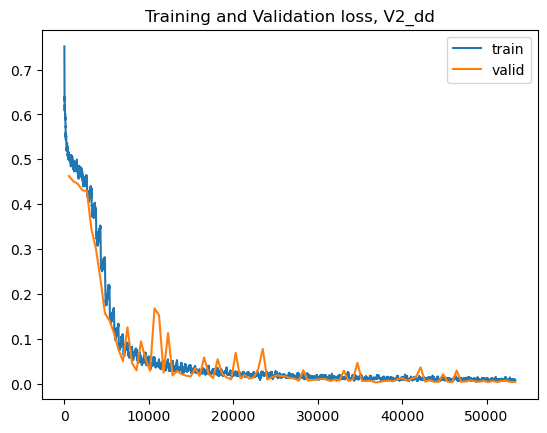

Testing base model...


  0%|          | 0/68 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NORM     0.9992    0.9975    0.9983      1189
          MI     0.9974    1.0000    0.9987       388
        STTC     1.0000    1.0000    1.0000       474
          CD     0.9958    1.0000    0.9979       470
         HYP     1.0000    1.0000    1.0000       224

   micro avg     0.9985    0.9989    0.9987      2745
   macro avg     0.9985    0.9995    0.9990      2745
weighted avg     0.9985    0.9989    0.9987      2745
 samples avg     0.9981    0.9988    0.9983      2745



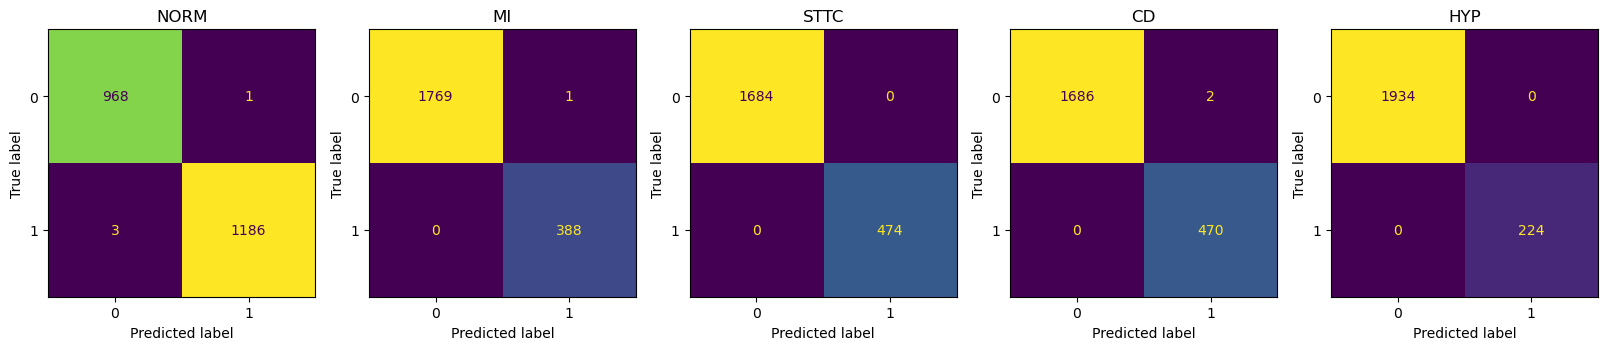

Testing pre-trained model...


  0%|          | 0/68 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NORM     0.9975    0.9983    0.9979      1189
          MI     0.9949    0.9974    0.9961       388
        STTC     1.0000    0.9979    0.9989       474
          CD     1.0000    1.0000    1.0000       470
         HYP     1.0000    1.0000    1.0000       224

   micro avg     0.9982    0.9985    0.9984      2745
   macro avg     0.9985    0.9987    0.9986      2745
weighted avg     0.9982    0.9985    0.9984      2745
 samples avg     0.9972    0.9981    0.9975      2745



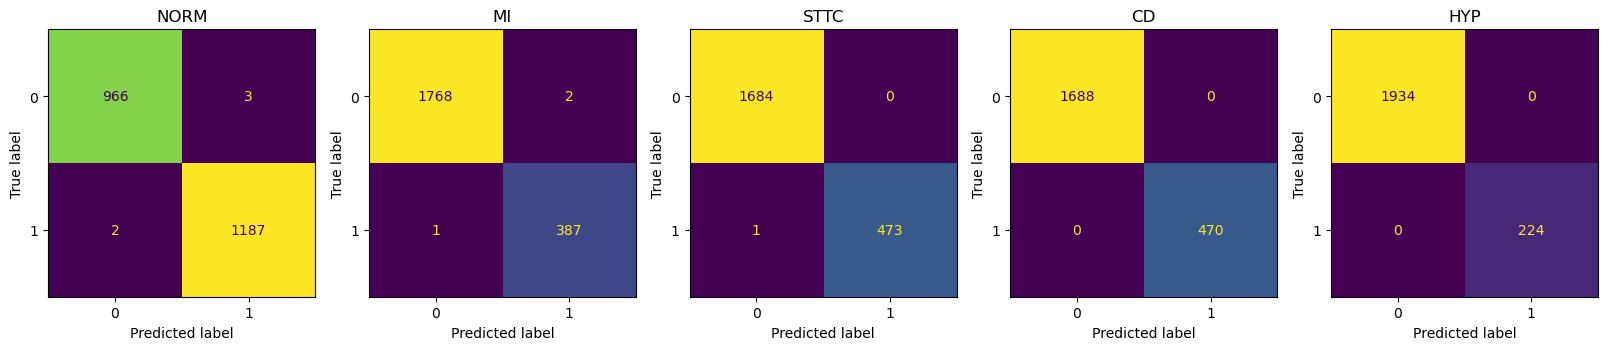

In [78]:
run_pipeline("V2")

In [79]:
# # getting loaders
# train_loader_nvp, val_loader_nvp, test_loader_nvp = get_nvp_loaders(ctx_length, pred_length, BATCH_SIZE, leads)
# train_loader_dd, val_loader_dd, test_loader_dd = get_dd_loaders(BATCH_SIZE, leads)

In [80]:
# reproduce()
# nvp_model, dd_model, base_dd_model = get_models(ctx_length, pred_length, channels)

In [81]:
# nvp_learner = get_nvp_learner(train_loader_nvp, val_loader_nvp, nvp_model)
# dd_learner = get_dd_learner(train_loader_dd, val_loader_dd, dd_model)
# base_dd_learner = get_dd_learner(train_loader_dd, val_loader_dd, base_dd_model)

In [82]:
# # first we train base_dd_learner
# fit_dd(base_dd_learner, EPOCHS, f"{fname}_base_dd", lr=1e-3)

In [83]:
# fit_nvp(nvp_learner, 30, lr=1e-3)

In [84]:
# # copy weights
# copy_weights(dd_learner.model, nvp_learner.model)

In [85]:
# fit_dd(dd_learner, EPOCHS, f"{fname}_dd", lr=1e-3)

In [86]:
# save_learning_curve(base_dd_learner, f"{fname}_base_dd")

In [87]:
# save_learning_curve(dd_learner, f"{fname}_dd")

In [88]:
# y_true, y_pred = test_model(base_dd_learner, test_loader_dd, f"{fname}_base_dd")
# evaluate(y_true, y_pred, f"{fname}_base_dd")

In [89]:
# y_true, y_pred = test_model(dd_learner, test_loader_dd, f"{fname}_dd")
# evaluate(y_true, y_pred, f"{fname}_dd")